In [1]:
import sys
sys.path.append('..')

import imageio
import matplotlib.pyplot as plt
from data import load

from util import plot_grid, benchmark, register_croco

import numpy as np
np.random.seed(123)

%load_ext autoreload
%autoreload 2

In [2]:
def fienup_phase_retrieval(mag, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of Fienup's phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    
    Note: Mode 'output-output' and beta=1 results in 
    the Gerchberg-Saxton algorithm.
    
    Parameters:
        mag: Measured magnitudes of Fourier transform
        mask: Binary array indicating where the image should be
              if padding is known
        beta: Positive step size
        steps: Number of iterations
        mode: Which algorithm to use
              (can be 'input-output', 'output-output' or 'hybrid')
        verbose: If True, progress is shown
    
    Returns:
        x: Reconstructed image
    
    Author: Tobias Uelwer
    Date: 30.12.2018
    
    References:
    [1] E. Osherovich, Numerical methods for phase retrieval, 2012,
        https://arxiv.org/abs/1203.4756
    [2] J. R. Fienup, Phase retrieval algorithms: a comparison, 1982,
        https://www.osapublishing.org/ao/abstract.cfm?uri=ao-21-15-2758
    [3] https://github.com/cwg45/Image-Reconstruction
    """
    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        y = np.real(np.fft.ifft2(y_hat))
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
            
        # find elements that violate object domain constraints 
        # or are not masked
        indices = np.logical_or(np.logical_and(y<0, mask), 
                                np.logical_not(mask))
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices] 
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        # (replace magnitude with input magnitude)
        y_hat = mag*np.exp(1j*np.angle(x_hat))
    return x

In [ ]:
size = 1024
restart = 3

beta = 0.8
steps = 1000

test_data = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5' ,batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 50==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(restart):
        res.append(fienup_phase_retrieval(magnitudes, beta=beta, steps=steps, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))
    results[i] = res[np.argmin(errors)]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_CelebA/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_CelebA/predicted_1.p", "wb"))

In [8]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/HIO_CelebA/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/HIO_CelebA/predicted_1.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


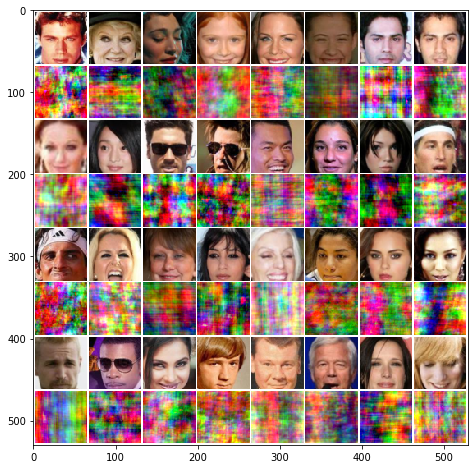

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


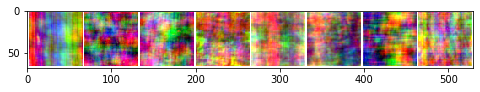

In [9]:
from util import plot_grid

to_plot = np.stack([batch[:32].reshape(4, 8*3, 64, 64), 
                    results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/CelebA_HIO.png")

plot_grid(results[24:32].reshape(-1, 3, 64, 64), figsize=(8,8), file="../out/hio/CelebA_HIO_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


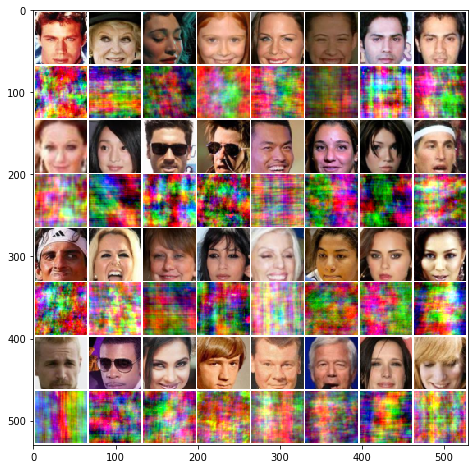

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


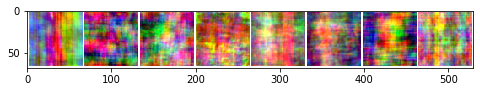

In [12]:
results_reg = register_croco(results, batch)

from util import plot_grid

to_plot = np.stack([batch[:32].reshape(4, 8*3, 64, 64), 
                    results_reg[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/CelebA_HIO_reg.png")

plot_grid(results_reg[24:32].reshape(-1, 3, 64, 64), figsize=(8,8), 
          file="../out/hio/CelebA_HIO_small_reg.png")

In [13]:
benchmark(results_reg, batch, check_all=True)

Signal error:
  MSE: 0.07372042370298004, std: 0.03244651843771393
  MAE: 0.20877534922328778, std: 0.04670521706913013
  SSIM: 0.2192877429450491, std: 0.05894294673212896
  Sharpness: 0.06546256801072858, std: 0.014328786709553405
  PhCo-MSE: 0.098122164268716, std: 0.044402109354815936
  PhCo-MAE: 0.24391586489218753, std: 0.05852338084648525
  PhCo-SSIM: 0.16711669343345442, std: 0.0634327698682897
  CroCo-MSE: 0.07372042370298004, std: 0.03244651843771393
  CroCo-MAE: 0.20877534922328778, std: 0.04670521706913013
  CroCo-SSIM: 0.2192877429450491, std: 0.05894294673212896

Magnitude error:
  MSE Magnitude: 3.4667535322167465e-13, std: 1.1817770633094631e-13

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 2.31] - should be in [0, 1]

Markdown table values:
 0.07372 | 0.2088 | 0.2193 | 0.06546 | 0.09812 | 0.2439 | 0.1671 | 0.07372 | 0.2088 | 0.2193 | 0.0000000000003467 |


## HIO CelebA

| Nr. | steps | restarts | beta | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1000 | 3 | 0.8 | 0.07372 | 0.2088 | 0.2193 | 0.06546 | 0.09812 | 0.2439 | 0.1671 | 0.07372 | 0.2088 | 0.2193 | 0.0000000000003467 |

In [51]:
size = 32
restart = 3

beta = 0.8
steps = 1000

mask = np.pad(np.ones((3, 64, 64)), ((0, 0), (32, 32), (32, 32)), mode='constant')

test_data = load(name='CelebApad', path='/home/shared/phase-retrieval/data/CelebA.h5' ,batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 50==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(restart):
        res.append(fienup_phase_retrieval(magnitudes, mask=mask, beta=beta, steps=steps, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))
    results[i] = res[np.argmin(errors)]

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


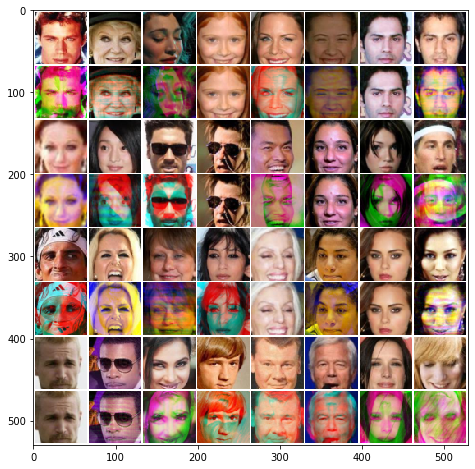

In [52]:
results_reg = register_croco(results, batch)

to_plot = np.stack([batch[:32, :, 32:96, 32:96].reshape(4, 8*3, 64, 64), 
                    results_reg[:32, :, 32:96, 32:96].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8))

In [55]:
benchmark(results_reg[:32, :, 32:96, 32:96], batch[:32, :, 32:96, 32:96], check_all=True)

Signal error:
  MSE: 0.02933626791302897, std: 0.025425589237946467
  MAE: 0.07794602717140986, std: 0.05664419773750737
  SSIM: 0.7407407228128051, std: 0.18103497702503257
  Sharpness: 0.025691840960281542, std: 0.018703583571677236
  PhCo-MSE: 0.030281374643825368, std: 0.02660671351184718
  PhCo-MAE: 0.08022677468935324, std: 0.060557909354414706
  PhCo-SSIM: 0.7350145435530391, std: 0.18884126569381296
  CroCo-MSE: 0.029373549221352116, std: 0.025452615859881338
  CroCo-MAE: 0.07823898353481962, std: 0.05700378045768853
  CroCo-SSIM: 0.7390528057201775, std: 0.18279352309774363

Magnitude error:
  MSE Magnitude: 0.1516960175962215, std: 0.4075537673506613

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.23] - should be in [0, 1]

Markdown table values:
 0.02934 | 0.07795 | 0.7407 | 0.02569 | 0.03028 | 0.08023 | 0.7350 | 0.02937 | 0.07824 | 0.7391 | 0.1517 |
